# Gamma-gamma Model

In this notebook we show how to fit a Gamma-Gamma model in PyMC-Marketing. We compare the results with the [`lifetimes`](https://github.com/CamDavidsonPilon/lifetimes) package (no longer maintained and last meaningful update was July 2020). The model is presented in the paper: Fader, P. S., & Hardie, B. G. (2013). [The Gamma-Gamma model of monetary value](http://www.brucehardie.com/notes/025/gamma_gamma.pdf). February, 2, 1-9.

## Prepare Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from lifetimes import GammaGammaFitter

from pymc_marketing import clv

# Plotting configuration
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Load Data

We start by loading the `CDNOW` dataset.

In [2]:
data_path = "https://raw.githubusercontent.com/pymc-labs/pymc-marketing/main/data/clv_quickstart.csv"

summary_with_money_value = pd.read_csv(data_path)
summary_with_money_value["customer_id"] = summary_with_money_value.index
summary_with_money_value.head()

,frequency,recency,T,monetary_value,customer_id
0,2,30.43,38.86,22.35,0
1,1,1.71,38.86,11.77,1
2,0,0.00,38.86,0.00,2
3,0,0.00,38.86,0.00,3
4,0,0.00,38.86,0.00,4


For the Gamma-Gamma model, we need to filter out customers who have made only one purchase.

In [3]:
returning_customers_summary = summary_with_money_value.query("frequency > 0")

returning_customers_summary.head()

,frequency,recency,T,monetary_value,customer_id
0,2,30.43,38.86,22.35,0
1,1,1.71,38.86,11.77,1
5,7,29.43,38.86,73.74,5
6,1,5.00,38.86,11.77,6
8,2,35.71,38.86,25.55,8


## Model Specification

Here we briefly describe the assumptions and the parametrization of the Gamma-Gamma model from the paper above.

The model of spend per transaction is based on the following three general assumptions:

- The monetary value of a customer’s given transaction varies randomly around their average transaction value.
- Average transaction values vary across customers but do not vary over time for any given individual.
- The distribution of average transaction values across customers is independent of the transaction process.
  
For a customer with x transactions, let $z_1, z_2, \ldots, z_x$ denote the value of each transaction. The customer’s observed average transaction value by

$$
\bar{z} = \frac{1}{x} \sum_{i=1}^{x} z_i
$$

Now let's describe the parametrization: 

1. We assume that $z_i \sim \text{Gamma}(p, ν)$, with $E(Z_i| p, ν) = \xi = p/ν$.

    – Given the convolution properties of the gamma, it follows that total spend across x transactions is distributed $\text{Gamma}(px, ν)$.

    – Given the scaling property of the gamma distribution, it follows that $\bar{z} \sim \text{Gamma}(px, νx)$.

2.  We assume $ν \sim \text{Gamma}(q, \gamma)$.

We are interested in estimating the parameters $p$, $q$ and $ν$.

```{note}
The Gamma-Gamma model assumes that there is no relationship between the monetary value and the purchase frequency. We can check this assumption by calculating the correlation between the average spend and the frequency of purchases.
```

In [4]:
returning_customers_summary[["monetary_value", "frequency"]].corr()

,monetary_value,frequency
monetary_value,1.000000,0.113884
frequency,0.113884,1.000000


The value of this correlation is close to $0.11$, which in practice is considered low enough to proceed with the model.

## Lifetimes Implementation

First, we fit the model using the `lifetimes` package.

In [5]:
ggf = GammaGammaFitter()
ggf.fit(
    returning_customers_summary["frequency"],
    returning_customers_summary["monetary_value"],
)

<lifetimes.GammaGammaFitter: fitted with 946 subjects, p: 6.25, q: 3.74, v: 15.45>

In [6]:
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,6.248802,1.189687,3.917016,8.580589
q,3.744588,0.290166,3.175864,4.313313
v,15.447748,4.159994,7.294160,23.601336


Once the model is fitted we can use the following method to compute the conditional expectation of the average profit per transaction for a group of one or more customers.

In [7]:
avg_profit = ggf.conditional_expected_average_profit(
    summary_with_money_value["frequency"], summary_with_money_value["monetary_value"]
)
avg_profit.head(10)

0    24.658616
1    18.911480
2    35.171002
3    35.171002
4    35.171002
5    71.462851
6    18.911480
7    35.171002
8    27.282408
9    35.171002
dtype: float64

In [8]:
avg_profit.mean()

35.25295817604993

## PyMC Marketing Implementation

We can use the pre-built PyMC Marketing implementation of the Gamma-Gamma model, which also provides nice plotting and prediction methods:

We can *build* the model so that we can see the model specification:

In [9]:
model = clv.GammaGammaModel(data=returning_customers_summary)
model.build_model()
model

Gamma-Gamma Model (Mean Transactions)
         p ~ HalfFlat()
         q ~ HalfFlat()
         v ~ HalfFlat()
likelihood ~ Potential(f(q, p, v))

```{note}
It is not necessary to build the model before fitting it. We can fit the model directly.
```

### Using MAP

To begin with, lets use a numerical optimizer (`L-BFGS-B`) from `scipy.optimize` to find the maximum a posteriori (MAP) estimate of the parameters.

In [10]:
idata_map = model.fit(method="map").posterior.to_dataframe()

Output()

In [11]:
idata_map

,,p,q,v
chain,draw,,,
0,0,6.248787,3.744591,15.447813


These values are very close to the ones obtained by the `lifetimes` package.

### MCMC

We can also use MCMC to sample from the posterior distribution of the parameters. MCMC is a more robust method than MAP and provides uncertainty estimates for the parameters.

In [12]:
sampler_kwargs = {
    "draws": 2_000,
    "target_accept": 0.9,
    "chains": 4,
    "random_seed": 42,
}

idata_mcmc = model.fit(**sampler_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [p, q, v]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 449 seconds.


In [13]:
idata_mcmc

Inference data with groups:
	> posterior
	> sample_stats
	> fit_data

We can see some statistics of the posterior distribution of the parameters.

In [14]:
model.fit_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,6.403,1.303,4.217,8.710,0.032,0.023,1686.0,1783.0,1.0
q,3.781,0.290,3.238,4.338,0.007,0.005,1753.0,2187.0,1.0
v,16.051,4.243,8.050,23.907,0.107,0.076,1563.0,1746.0,1.0


Let's visualize the posterior distributions and the rank plot:

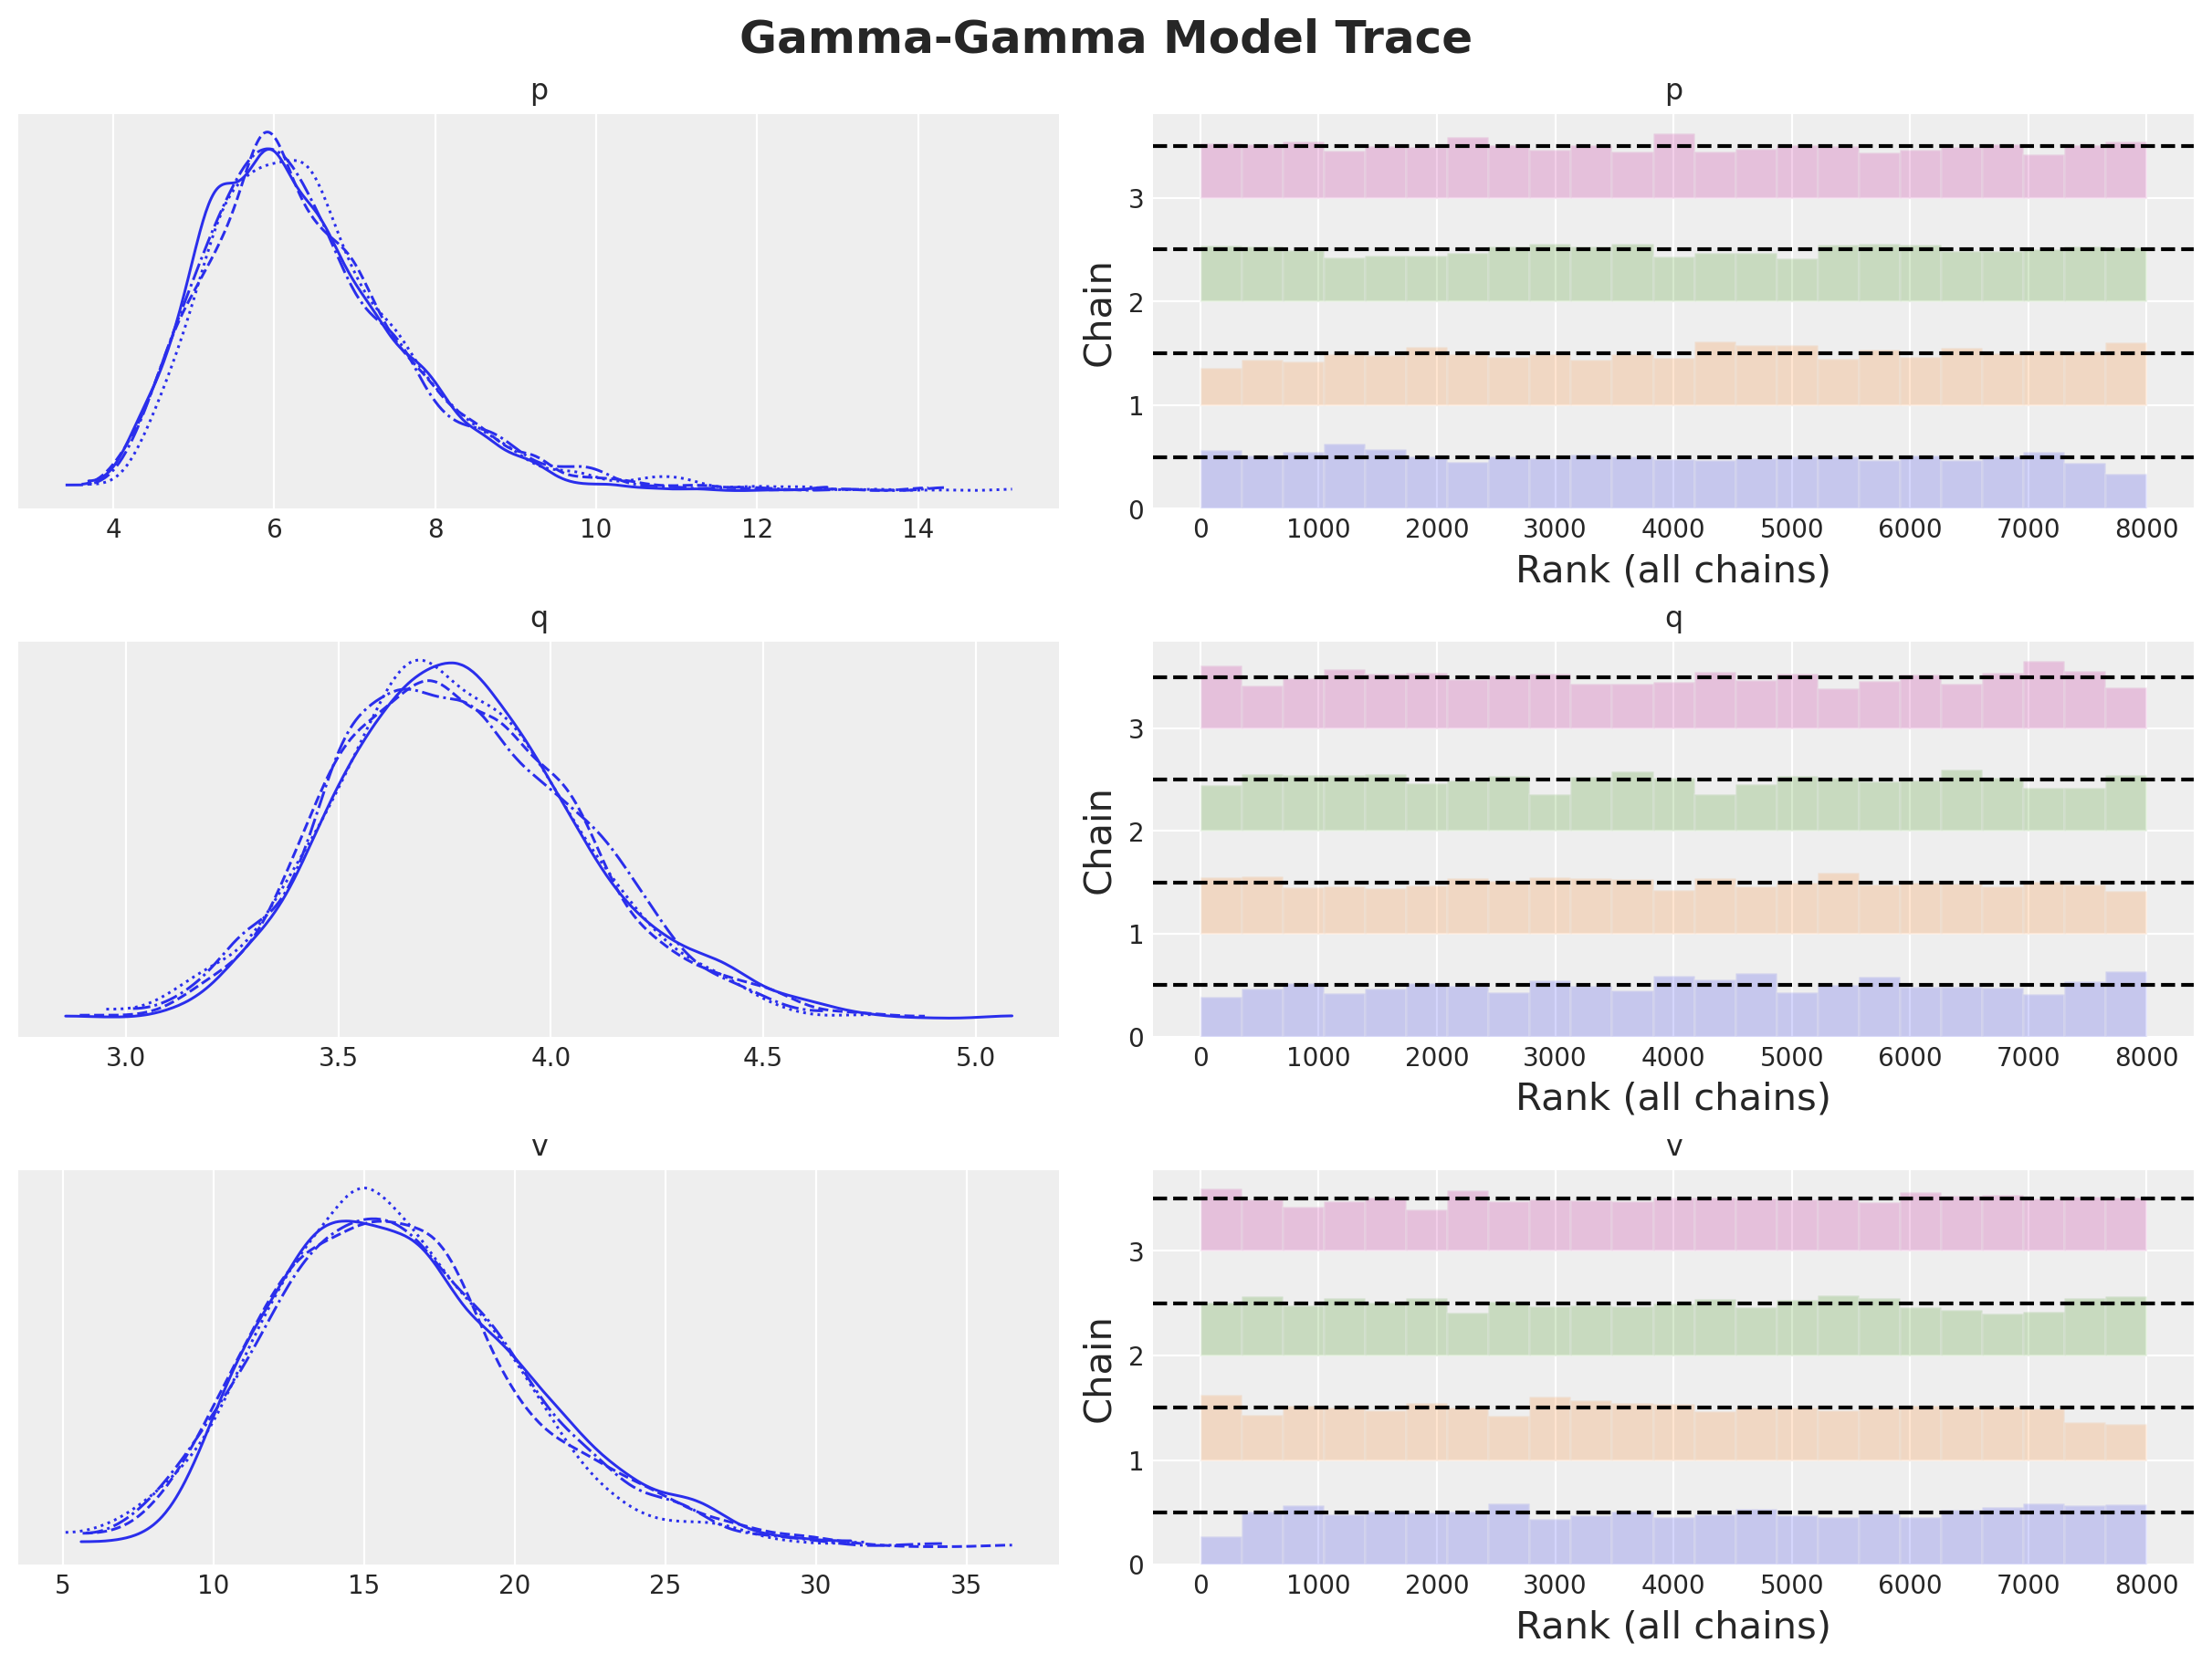

In [15]:
axes = az.plot_trace(
    data=model.idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle("Gamma-Gamma Model Trace", fontsize=18, fontweight="bold");

We can compare the results with the ones obtained by the `lifetimes` package and the MAP estimation.

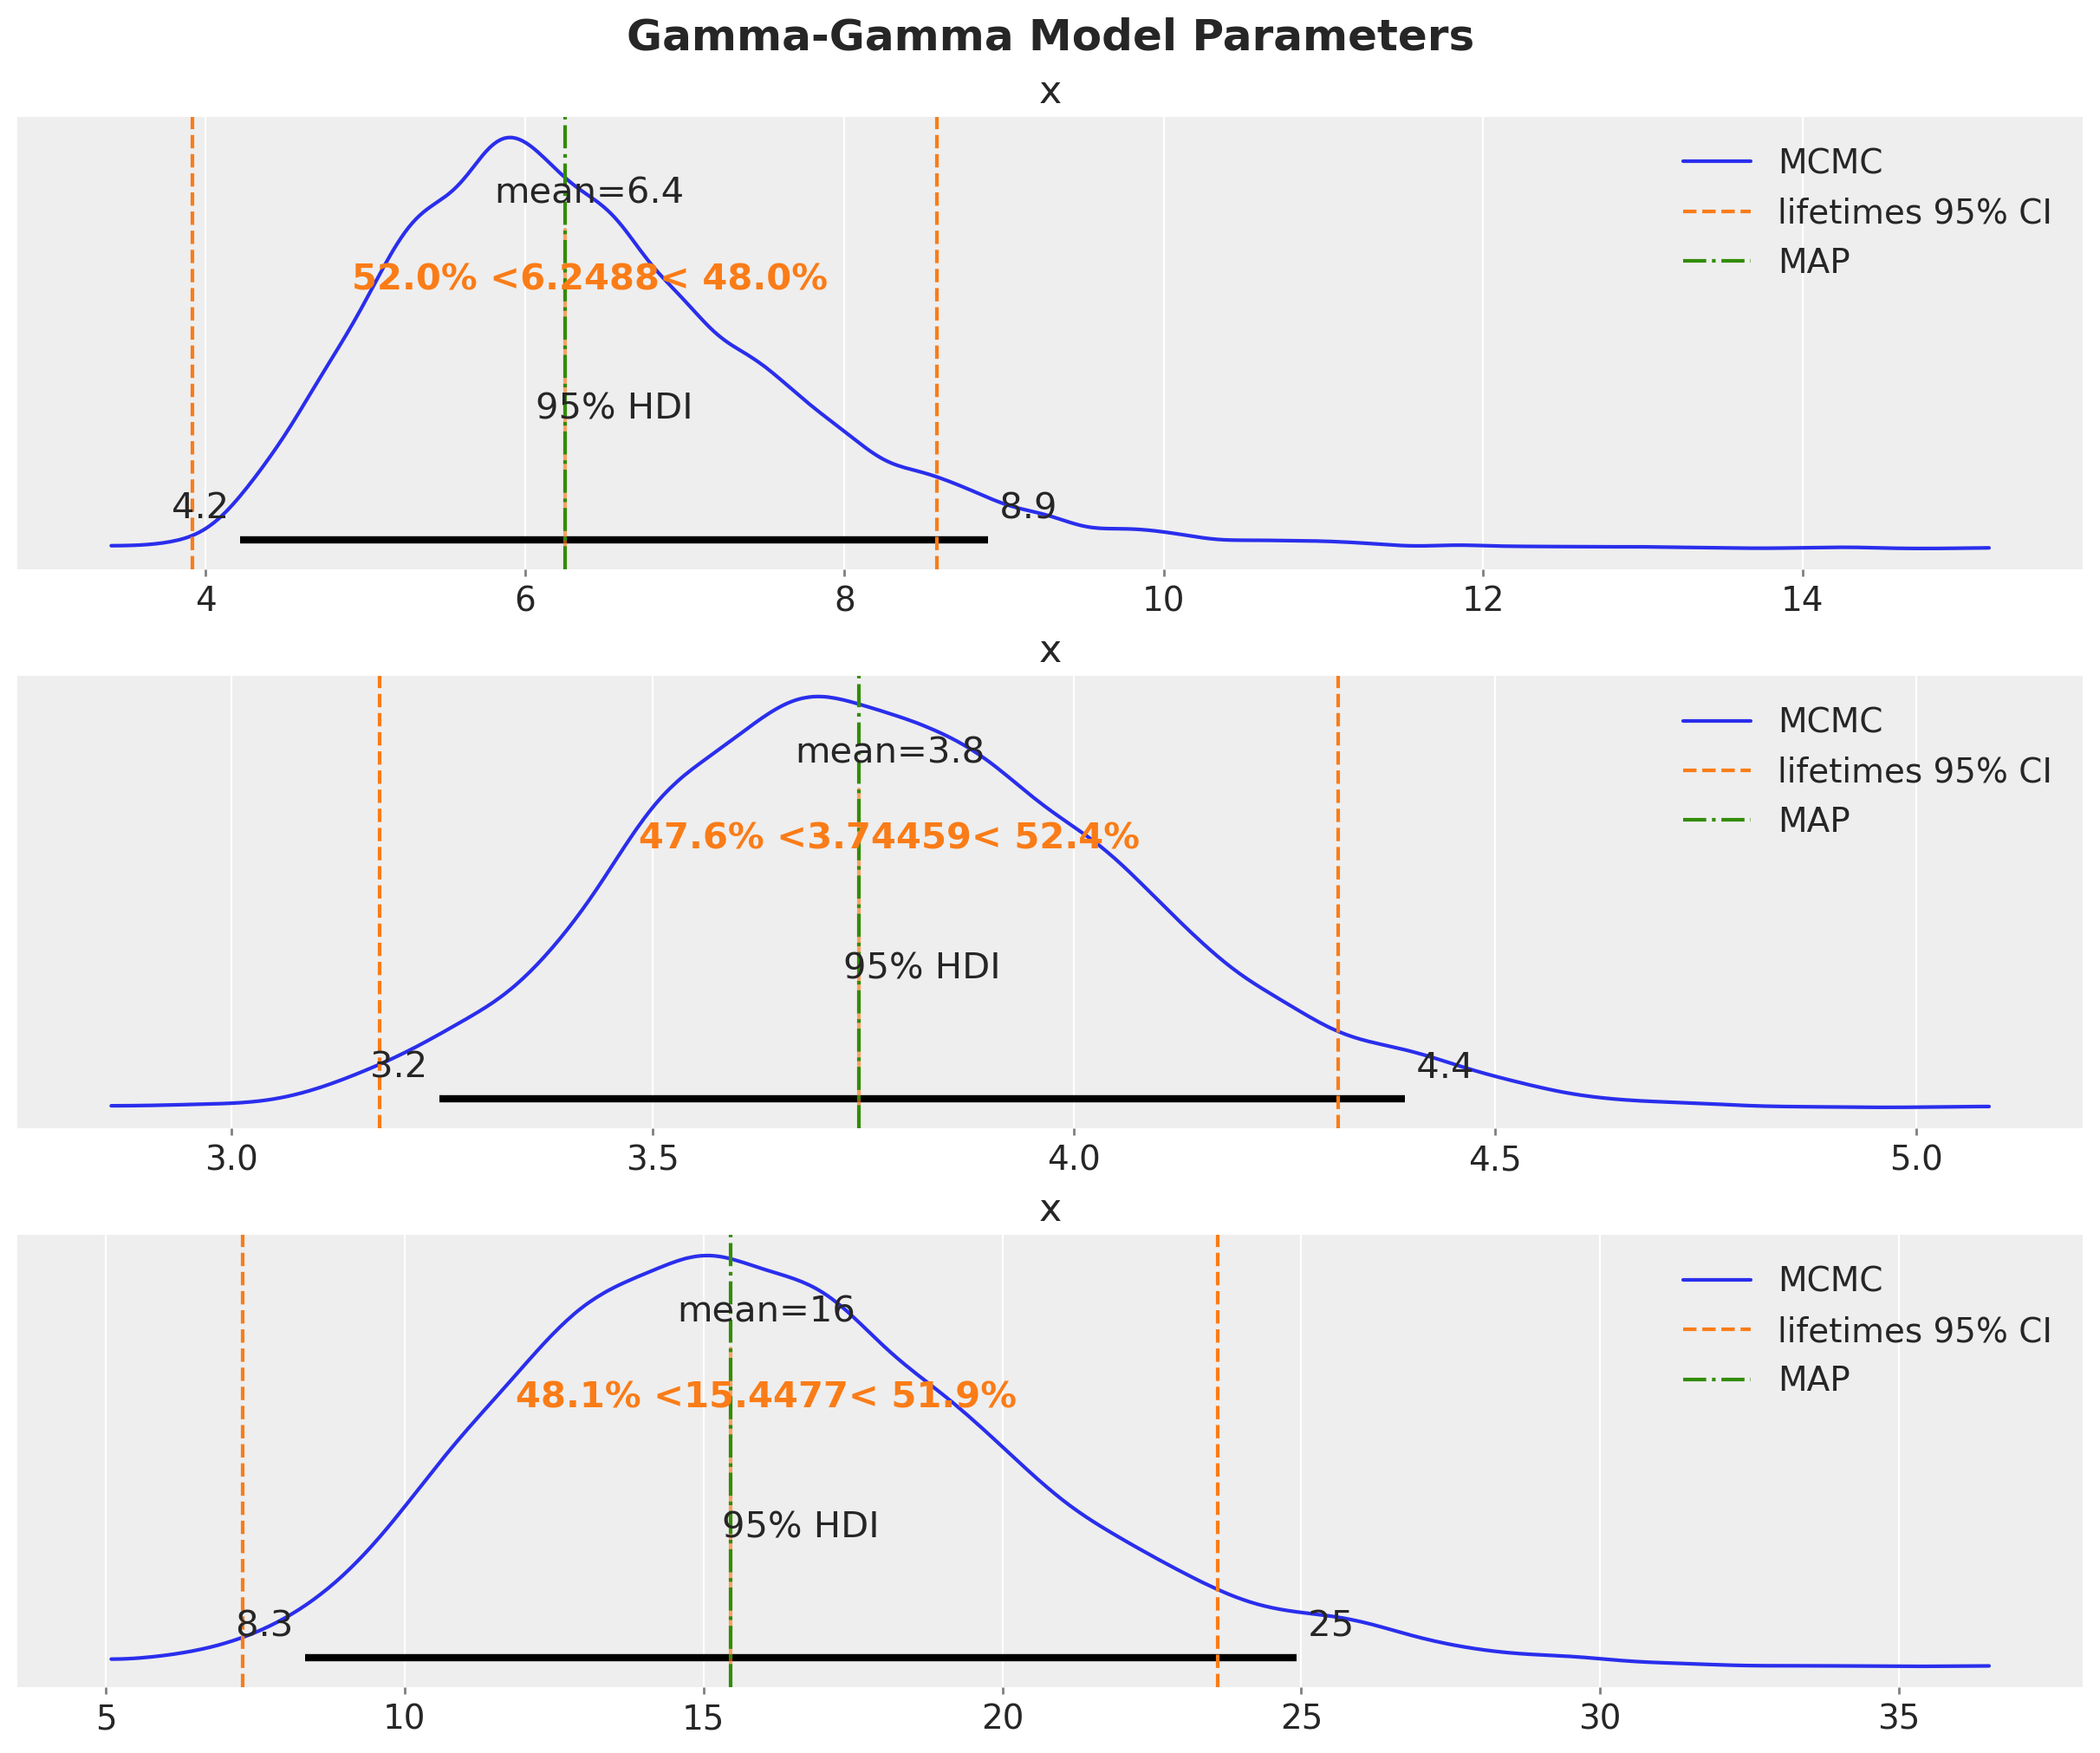

In [16]:
fig, axes = plt.subplots(
    nrows=3, ncols=1, figsize=(12, 10), sharex=False, sharey=False, layout="constrained"
)

for i, var_name in enumerate(["p", "q", "v"]):
    ax = axes[i]
    az.plot_posterior(
        idata_mcmc.posterior[var_name].values.flatten(),
        color="C0",
        point_estimate="mean",
        hdi_prob=0.95,
        ref_val=ggf.summary["coef"][var_name],
        ax=ax,
        label="MCMC",
    )
    ax.axvline(
        x=ggf.summary["lower 95% bound"][var_name],
        color="C1",
        linestyle="--",
        label="lifetimes 95% CI",
    )
    ax.axvline(
        x=ggf.summary["upper 95% bound"][var_name],
        color="C1",
        linestyle="--",
    )
    ax.axvline(x=idata_map[var_name].item(), color="C2", linestyle="-.", label="MAP")
    ax.legend(loc="upper right")

plt.gcf().suptitle("Gamma-Gamma Model Parameters", fontsize=18, fontweight="bold");

We see that the `lifetimes` and MAP estimates are essentially the same. Both of them are close to the mean of the posterior distribution obtained by MCMC.

## Expected Customer Spend

Once we have the posterior distribution of the parameters, we can use the `expected_average_profit` method to compute the conditional expectation of the average profit per transaction for a group of one or more customers.

In [17]:
expected_spend = model.expected_customer_spend(data=summary_with_money_value)

Let's see how it looks for a subset of customers.

In [18]:
az.summary(expected_spend.isel(customer_id=range(10)), kind="stats")

,mean,sd,hdi_3%,hdi_97%
x[0],24.706,0.512,23.839,25.762
x[1],18.994,1.311,16.641,21.547
x[2],35.195,0.924,33.447,36.887
x[3],35.195,0.924,33.447,36.887
x[4],35.195,0.924,33.447,36.887
x[5],71.387,0.599,70.165,72.409
x[6],18.994,1.311,16.641,21.547
x[7],35.195,0.924,33.447,36.887
x[8],27.318,0.394,26.627,28.107
x[9],35.195,0.924,33.447,36.887


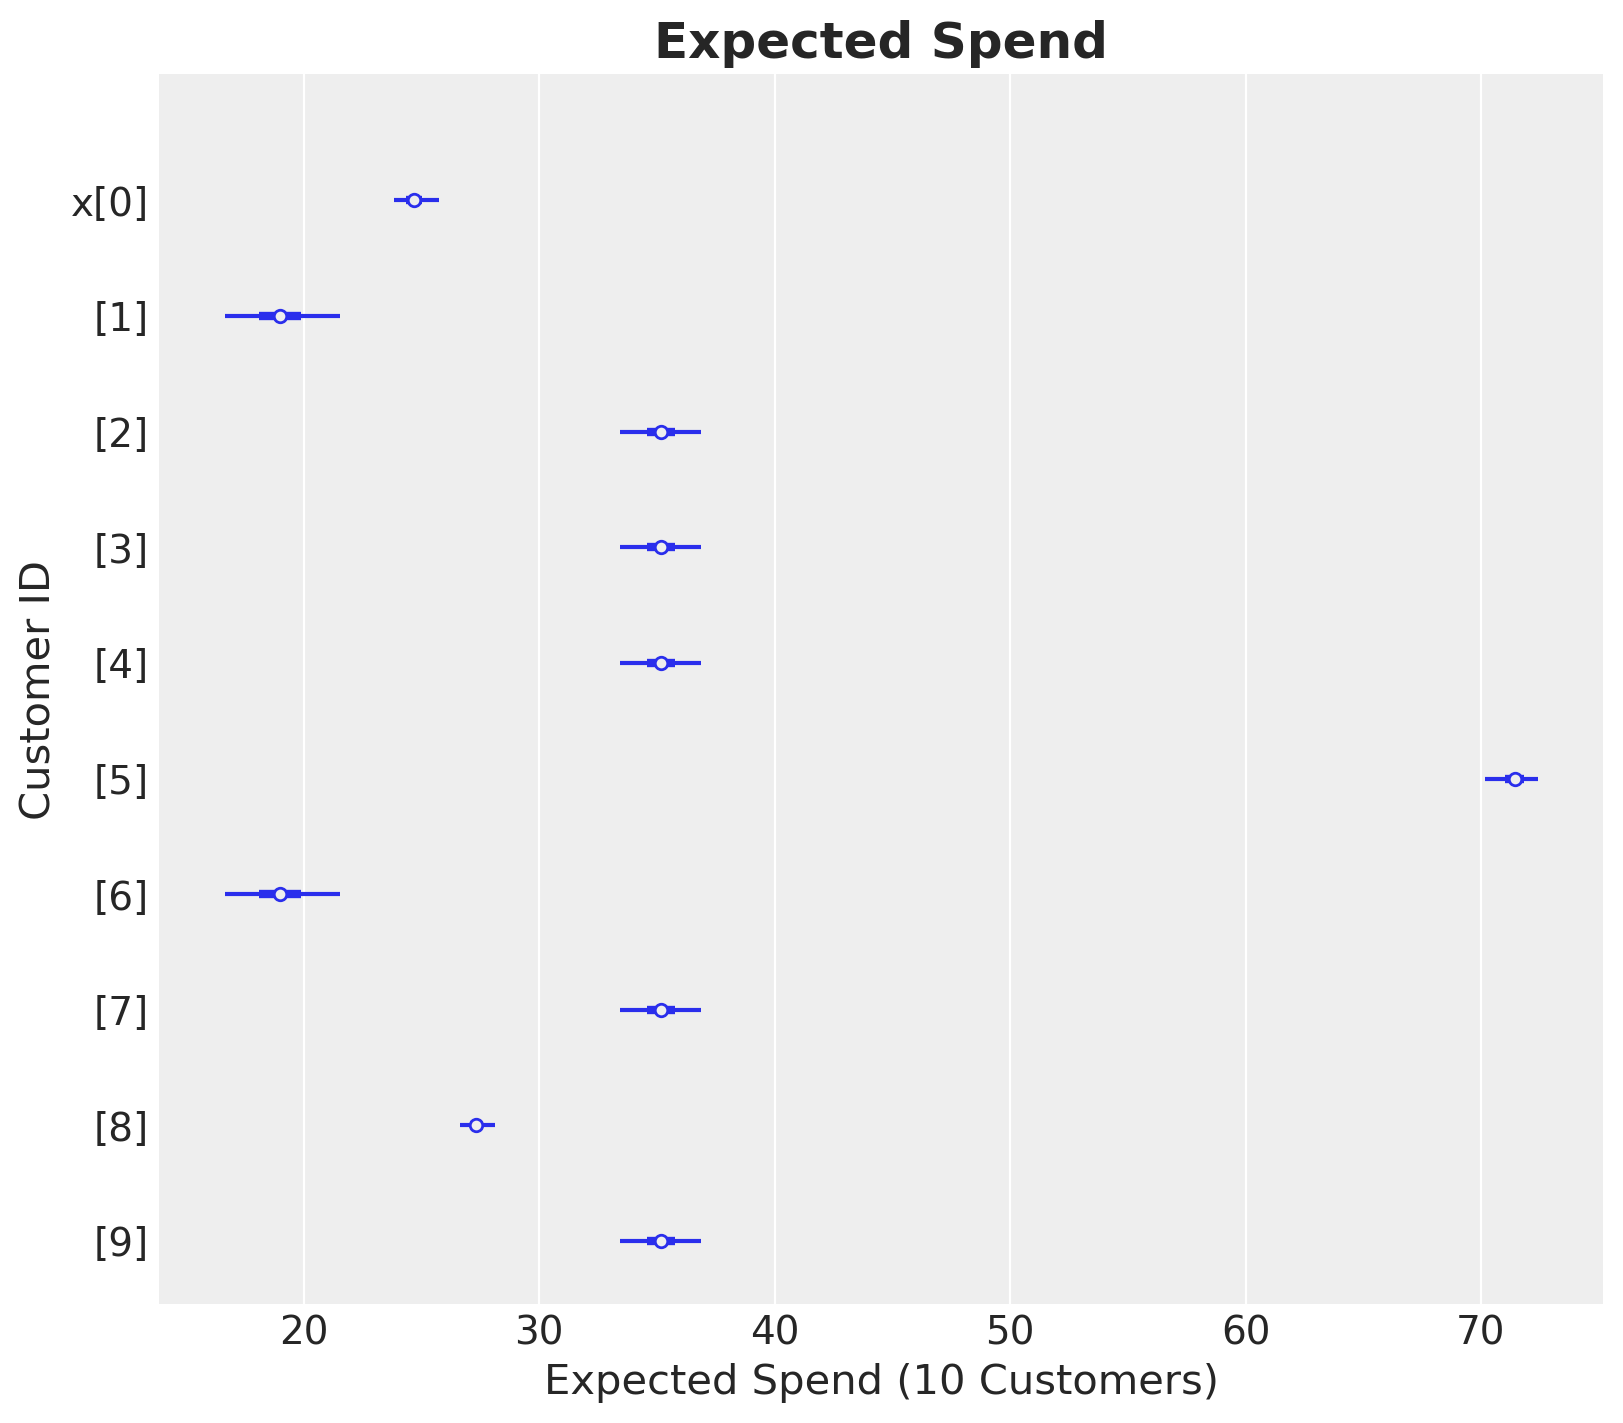

In [19]:
ax, *_ = az.plot_forest(
    data=expected_spend.isel(customer_id=(range(10))), combined=True, figsize=(8, 7)
)
ax.set(xlabel="Expected Spend (10 Customers)", ylabel="Customer ID")
ax.set_title("Expected Spend", fontsize=18, fontweight="bold");

Finally, lets look at some statistics and the distribution for the whole dataset.

In [20]:
az.summary(expected_spend.mean("customer_id"), kind="stats")

,mean,sd,hdi_3%,hdi_97%
x,35.268,0.629,34.107,36.442


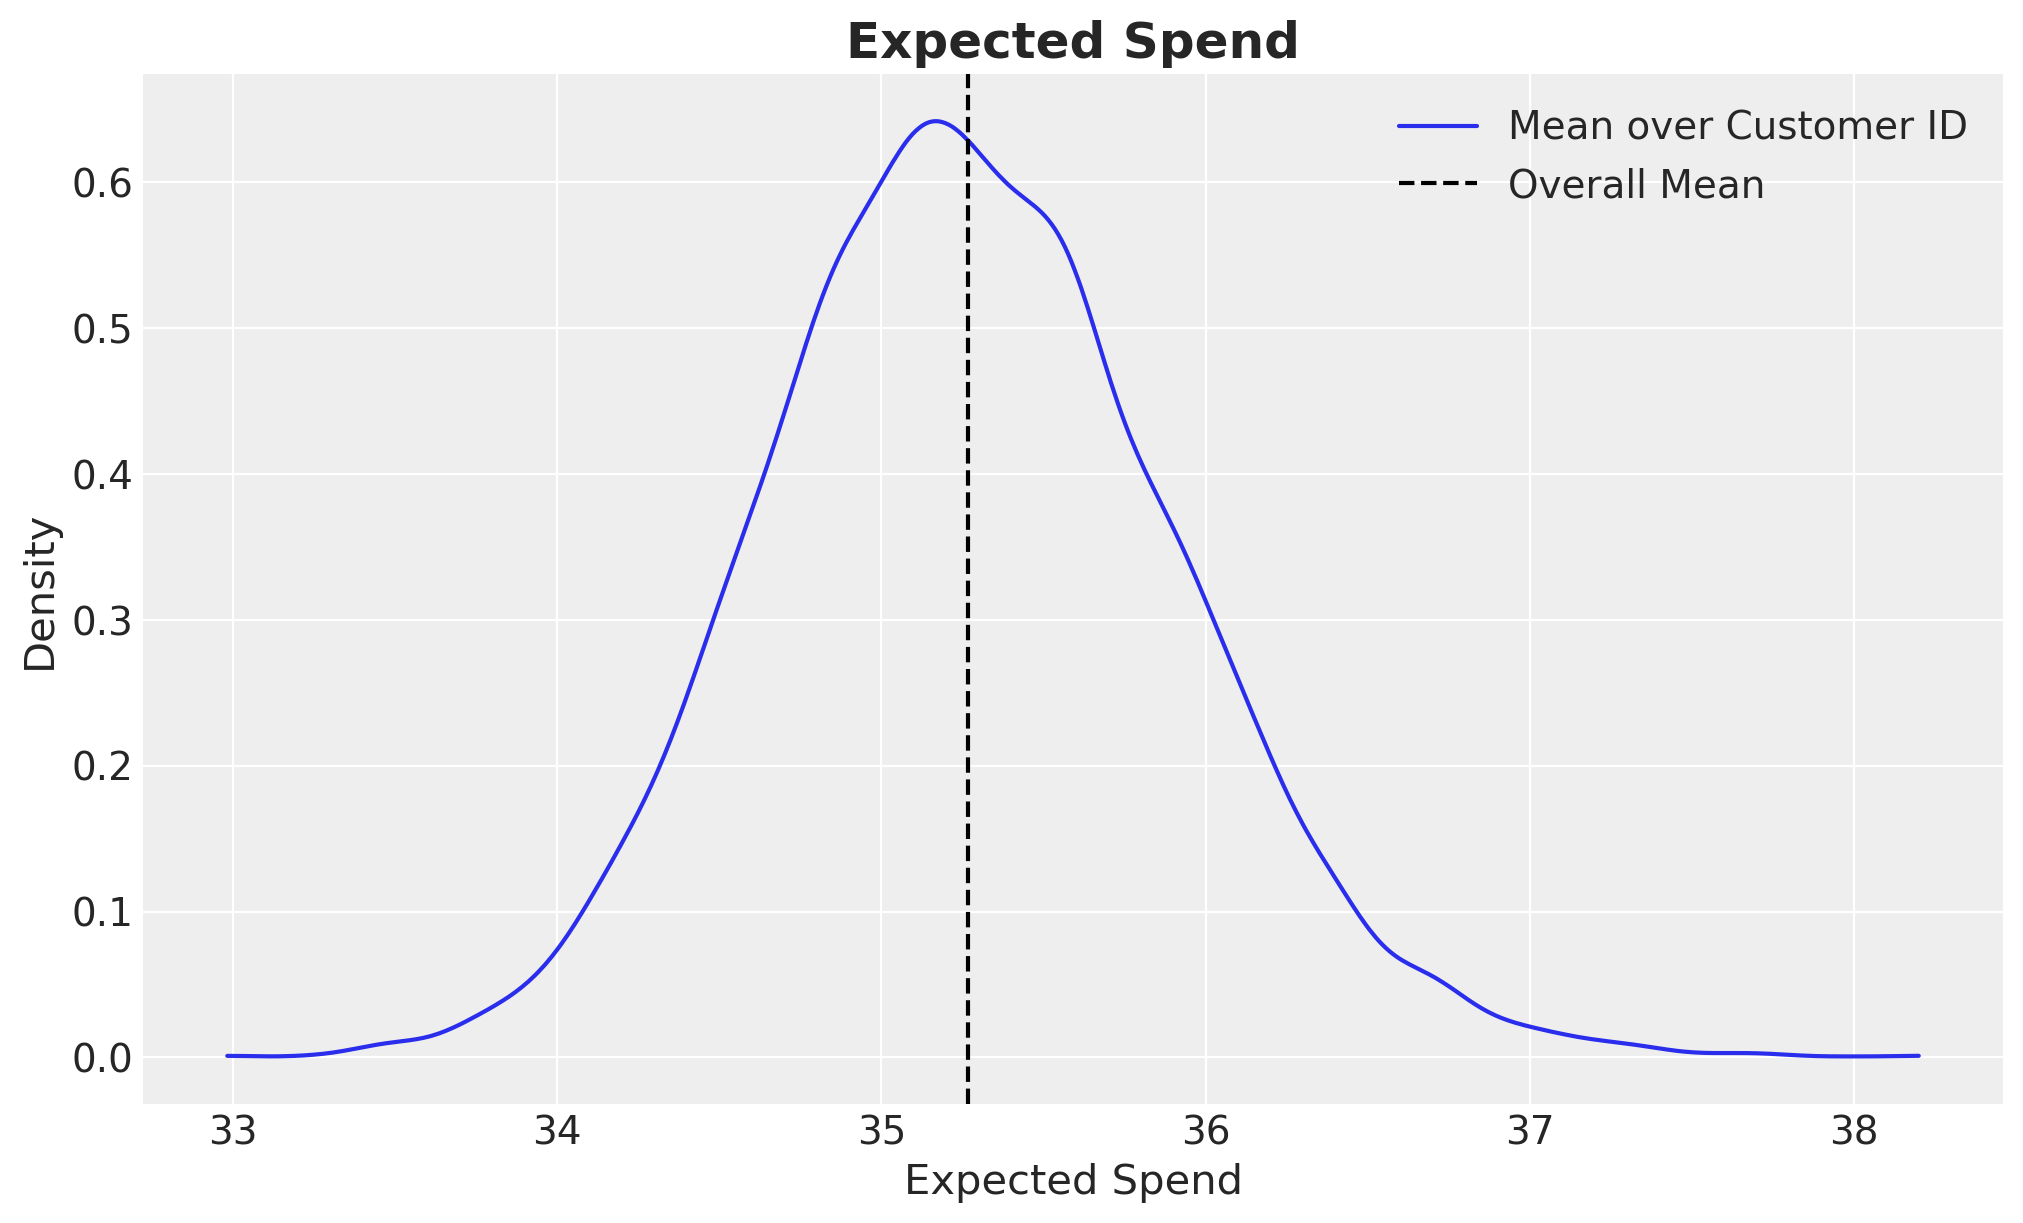

In [21]:
fig, ax = plt.subplots()
az.plot_dist(expected_spend.mean("customer_id"), label="Mean over Customer ID", ax=ax)
ax.axvline(x=expected_spend.mean(), color="black", ls="--", label="Overall Mean")
ax.legend(loc="upper right")
ax.set(xlabel="Expected Spend", ylabel="Density")
ax.set_title("Expected Spend", fontsize=18, fontweight="bold");

In [22]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc,pytensor

Last updated: Mon Jul 01 2024

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.22.2

pymc    : 5.14.0
pytensor: 2.20.0

arviz         : 0.17.1
pymc_marketing: 0.6.0
matplotlib    : 3.8.3
pandas        : 2.2.1

Watermark: 2.4.3

